In [5]:
############################################################################
### Implement Conditional Variational Autoencoder (cVAE) for MNIST data set
############################################################################

# Import modules
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
import matplotlib.pyplot as plt

# Set plotting style
plt.style.use('seaborn-ticks')

# Define a function to look at MNIST images
def imshow(images, labels=None, num_images_display=5):
    # Arrange images on a grid
    img = torchvision.utils.make_grid(images[:num_images_display])
    
    # Make the images a numpy array
    np_img = img.numpy()
    
    # Show the images
    plt.imshow(np.transpose(np_img, (1, 2, 0)), cmap='Greys')
    plt.axis('off')
    plt.show()
    
    # Display the labels if they are provided
    if labels is not None:
        print(" ".join([f"{torch.argmax(label)}" for label in labels[:num_images_display]]))

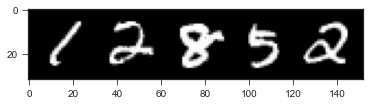

1 2 8 5 2
torch.Size([250, 10])


In [2]:
# Define random seed
torch.manual_seed(42)

# Define the batch size
batch_size = 250

# There are 10 digits thus 10 labels
num_labels = 10

# Define the transformations
# Transformations for X (images)
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize([0.5], [0.5]),
    ])
# Transformations for labels
target_transform = torchvision.transforms.Compose([
    lambda x: torch.LongTensor([x]),
    lambda x: F.one_hot(x, num_labels).flatten(),
])

# Train Data
train_set = torchvision.datasets.MNIST(root='./mnist', train=True, download=True, transform=transform, target_transform=target_transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

# Test Data
test_set = torchvision.datasets.MNIST(root='./mnist', train=False, download=True, transform=transform, target_transform=target_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

# Show the images
dataiter = iter(train_loader)
images, one_hot_labels = dataiter.next()

# Display some images
imshow(images, labels=one_hot_labels)

print(one_hot_labels.shape)

Definition complete


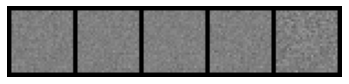

In [50]:
# Define model
class Net(nn.Module):
    def __init__(self):
        # Initialize super class
        super().__init__()
        
        # Define hyper parameters
        self.dim_input  = 28*28
        self.dim_one_hot_labels = num_labels
        self.dim_hidden = 512
        self.dim_latent = 2        
        
        # Define components
        # Encoder
        self.fc1         = nn.Linear(self.dim_input+self.dim_one_hot_labels, self.dim_hidden)
        self.fc2_mu      = nn.Linear(self.dim_hidden, self.dim_latent)
        self.fc2_log_var = nn.Linear(self.dim_hidden, self.dim_latent)
        
        # Decoder
        self.fc3 = nn.Linear(self.dim_latent+self.dim_one_hot_labels, self.dim_hidden)
        self.fc4 = nn.Linear(self.dim_hidden, self.dim_input)
        
    def flatten(self, x):
        """ Flatten inputs. """
        return torch.flatten(x, 1)
    
    def unflatten(self, x):
        """ Unflatted inputs. """
        return x.view(-1, 1, 28, 28)
    
    def concat_with_labels(self, x, one_hot_labels):
        """ Concatenate x with the one hot labels. """
        # Concatenate the inputs with the one_hot_labels
        return torch.cat([x, one_hot_labels], 1)
        
    def encode(self, x, one_hot_labels):
        """ Encode x. """
        # Flatten the inputs
        x = self.flatten(x)
        
        # Concatenate the inputs with the one_hot_labels
        x = self.concat_with_labels(x, one_hot_labels)
        
        x = F.relu( self.fc1(x) )
        mu      = self.fc2_mu(x)
        log_var = self.fc2_log_var(x)
        return mu, log_var

    def reparametrize(self, mu, log_var):
        """ Use reparameterization trick to avoid gradients of RVs. """
        # sigma = sqrt(var) = [exp( log(var) )]^0.5 = exp( 0.5*log(var) )
        sigma = torch.exp(0.5*log_var)
        
        # Sample normal random distribution
        eps = torch.randn_like(sigma)
        
        # Sample z
        z = mu+eps*sigma
        
        return z
    
    def decode(self, x, one_hot_labels):
        """ Decode x. """
        # Concatenate x with the labels
        x = self.concat_with_labels(x, one_hot_labels)
        
        # Images should have values in [0, 1]
        x = F.relu( self.fc3(x) )
        x = torch.sigmoid( self.fc4(x) )
        
        # Unflatten the inputs
        x = self.unflatten(x)
        
        return x
        
    def forward(self, x, one_hot_labels):
        """ Define forward pass decode(encode(x)). """
        mu, log_var = self.encode(x, one_hot_labels)
        z = self.reparametrize(mu, log_var)
        x = self.decode(z, one_hot_labels)
        return x, mu, log_var
    
    def sample(self, label, z=None, num_samples=1):
        """ Sample by feeding random number to decoder. """
        # Use input z if passed and if not passed, sample it 
        # from Gaussian centered at origin
        if z is None:
            z = torch.randn(num_samples, self.dim_latent)
        
        # Make the label(s) one hot encoded
        one_hot_labels = self.map_label_to_one_hot(label, num_samples)
        
        # Feed this into decoder and return it
        return self.decode(z, one_hot_labels)
    
    def map_label_to_one_hot(self, label, dim0_size):
        """ Map the label to a one-hot encoded label. """
        labels = np.ones( dim0_size)*label
        return F.one_hot(torch.LongTensor(labels), self.dim_one_hot_labels)
    
    def morph(self, label_1, label_2, z=None, num_steps=10):
        """ Morph/Interpolate from label_1 to label_2. """
        # Use input z if passed and if not passed, sample it 
        # from Gaussian centered at origin
        if z is None:
            z = torch.randn(1, self.dim_latent)
        
        # Make the label(s) one hot encoded
        one_hot_labels_1 = self.map_label_to_one_hot(label_1, 1)
        one_hot_labels_2 = self.map_label_to_one_hot(label_2, 1)
        print(one_hot_labels_1.shape)
        print(one_hot_labels_2.shape)
        print(z.shape)
        
        # Morph from label 1 to label 2
        steps = np.linspace(0, 1, num_steps)
        
        # Loop over the interpolation
        images_list = list()
        for step in steps:
            # Interpolate between the onehot labels
            one_hot_labels = one_hot_labels_1*(1-step)+one_hot_labels_2*step
            
            # Decode
            images_list.append( self.decode(z, one_hot_labels) )
            
        # Stack the images
        images = torch.vstack( images_list )
        print(images.shape)
        
        return images
        

# Initialize the network
net = Net()

# Define the criterion
def criterion_func(inputs, outputs, mu, log_var):
    """ Define a loss criterion. """
    # Reconstruction loss
    MSE = nn.MSELoss(reduction='sum')
    reconstruction_loss = MSE(inputs, outputs)
    #reconstruction = F.binary_cross_entropy(inputs, outputs, reduction='mean')
    
    # Latent Space - Gaussian loss
    latent_loss = -0.5*torch.sum(1+log_var-mu.pow(2)-log_var.exp())
    #print(f"{reconstruction}/{gaussian_latent}")
    
    # Total loss
    total_loss = reconstruction_loss + latent_loss
    
    return total_loss, reconstruction_loss, latent_loss

# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

print('Definition complete')

# Draw initial outputs
outputs, mu, log_var = net(images, one_hot_labels)
imshow(outputs)

[0-239] Loss: 12121.181827799479


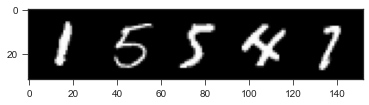

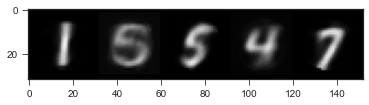

[1-239] Loss: 8774.412679036459


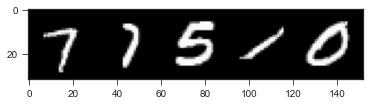

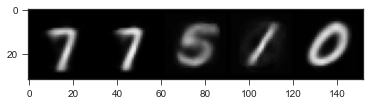

[2-239] Loss: 8388.187929280599


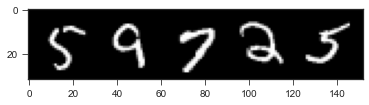

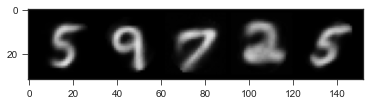

[3-239] Loss: 8200.939170328777


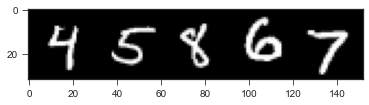

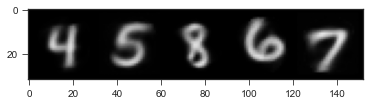

[4-239] Loss: 8070.887866210937


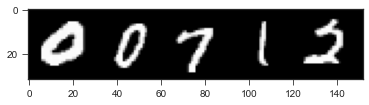

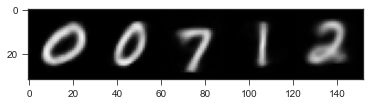

[5-239] Loss: 7980.571362304688


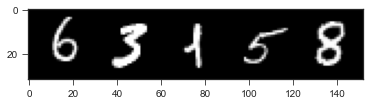

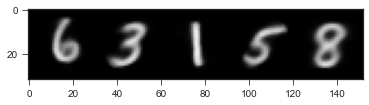

[6-239] Loss: 7907.933052571615


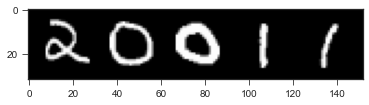

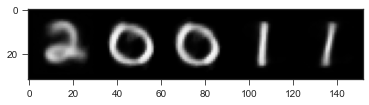

[7-239] Loss: 7854.264774576823


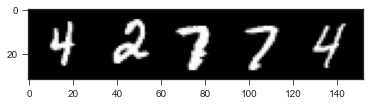

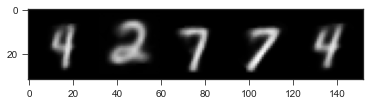

[8-239] Loss: 7808.193794759115


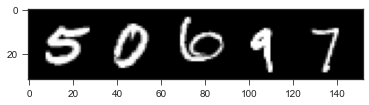

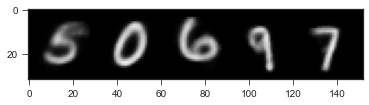

[9-239] Loss: 7770.694604492188


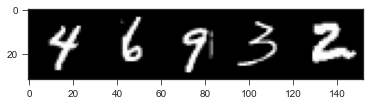

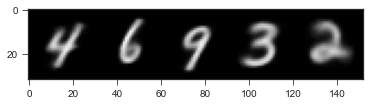

[10-239] Loss: 7736.980458577474


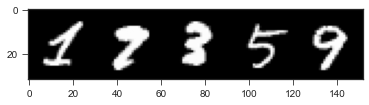

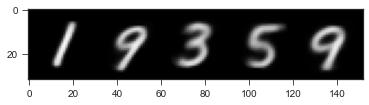

[11-239] Loss: 7708.266646321615


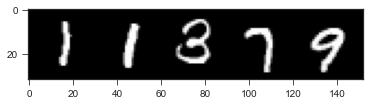

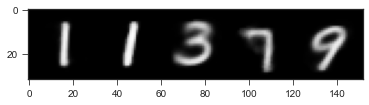

[12-239] Loss: 7682.629372151693


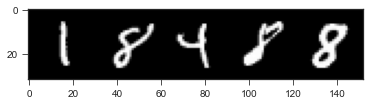

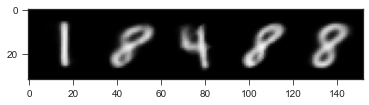

[13-239] Loss: 7666.191194661458


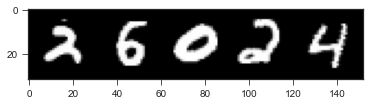

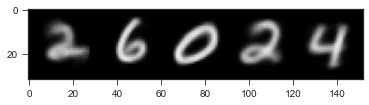

[14-239] Loss: 7643.758772786458


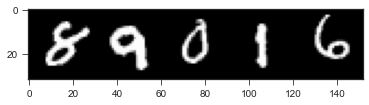

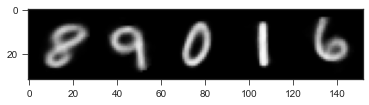

[15-239] Loss: 7627.859926350911


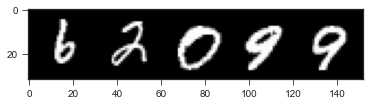

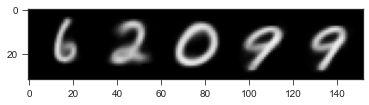

[16-239] Loss: 7608.430214436849


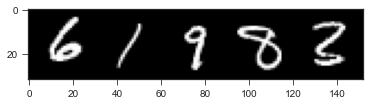

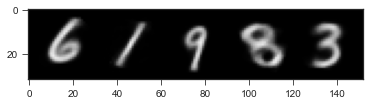

[17-239] Loss: 7595.559431966146


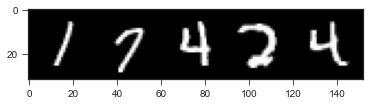

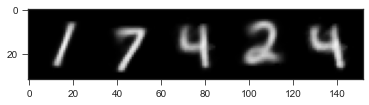

[18-239] Loss: 7586.759547932943


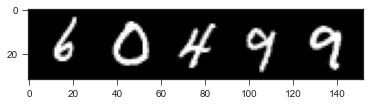

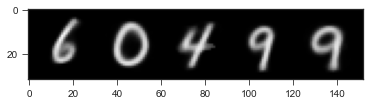

[19-239] Loss: 7570.361466471354


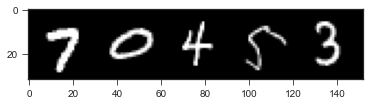

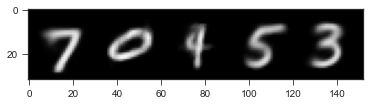

[20-239] Loss: 7560.320648193359


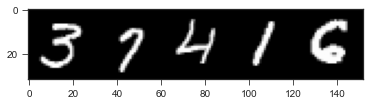

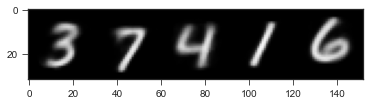

[21-239] Loss: 7550.122792561849


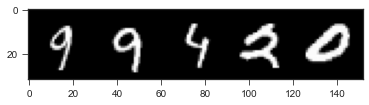

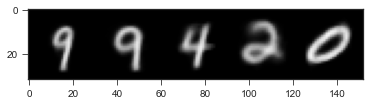

[22-239] Loss: 7541.025856526693


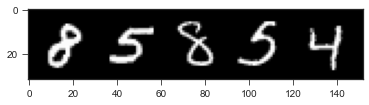

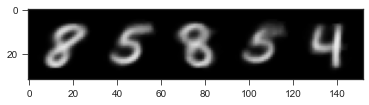

[23-239] Loss: 7535.889544677734


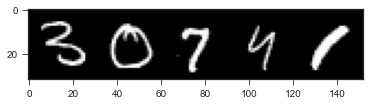

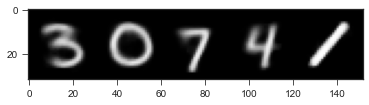

[24-239] Loss: 7523.201926676432


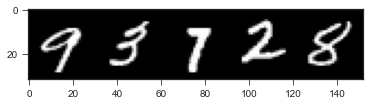

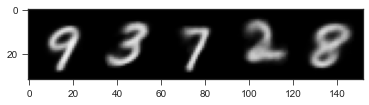

[25-239] Loss: 7515.66923828125


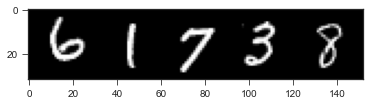

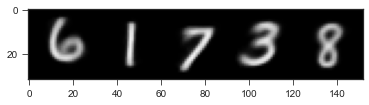

[26-239] Loss: 7511.51533610026


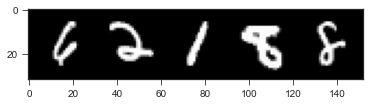

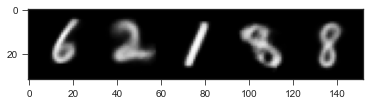

[27-239] Loss: 7506.293141682942


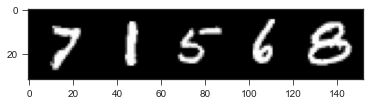

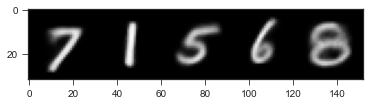

[28-239] Loss: 7498.9149719238285


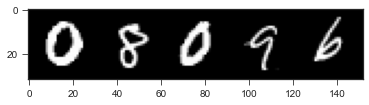

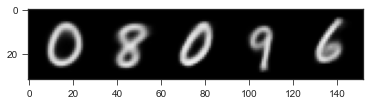

[29-239] Loss: 7489.372794596354


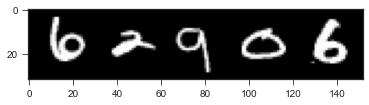

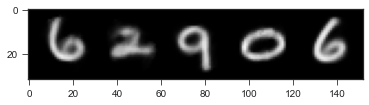

[30-239] Loss: 7484.122613525391


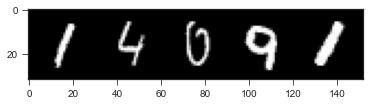

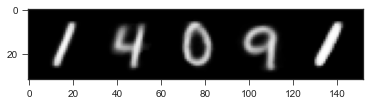

[31-239] Loss: 7481.663303629557


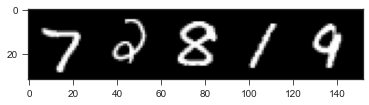

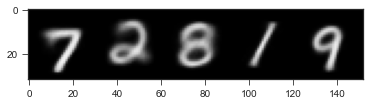

[32-239] Loss: 7473.958520507813


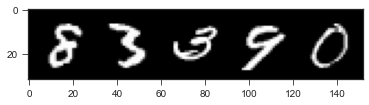

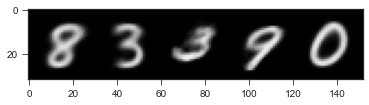

[33-239] Loss: 7469.213195800781


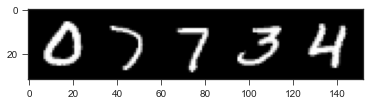

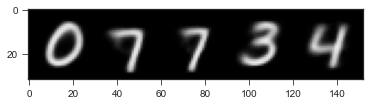

[34-239] Loss: 7464.5928955078125


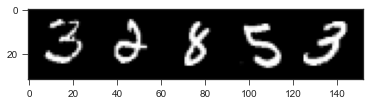

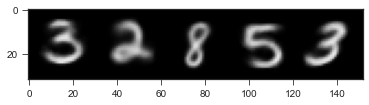

[35-239] Loss: 7458.717097981771


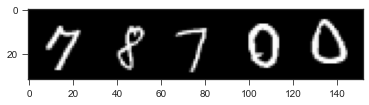

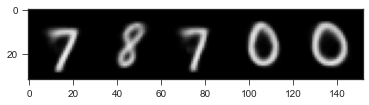

[36-239] Loss: 7452.148470052083


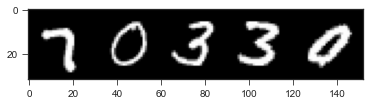

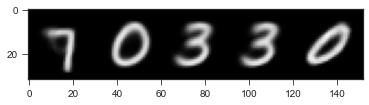

[37-239] Loss: 7452.550474039714


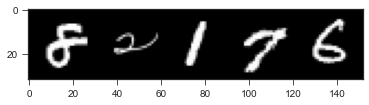

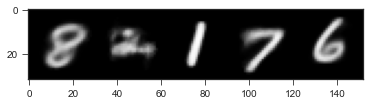

[38-239] Loss: 7444.37842203776


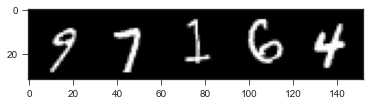

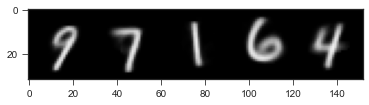

[39-239] Loss: 7440.033386230469


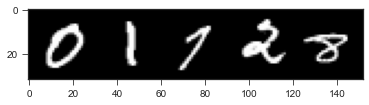

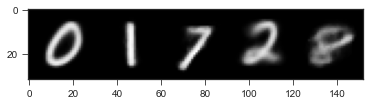

[40-239] Loss: 7435.302982584635


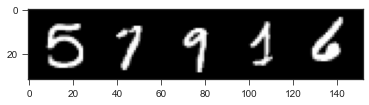

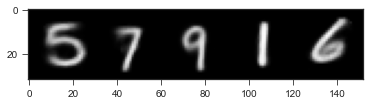

[41-239] Loss: 7434.639361572265


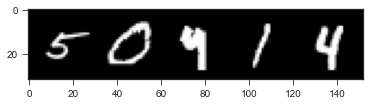

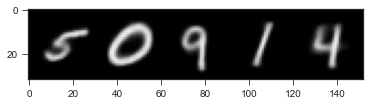

[42-239] Loss: 7433.161511230469


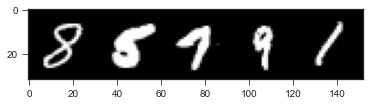

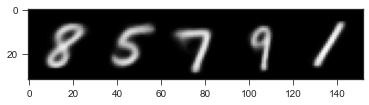

[43-239] Loss: 7424.371466064453


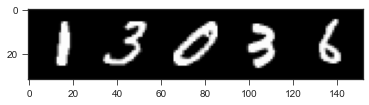

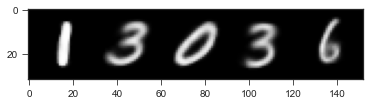

[44-239] Loss: 7420.97241007487


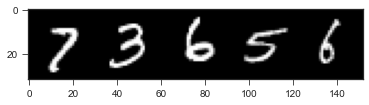

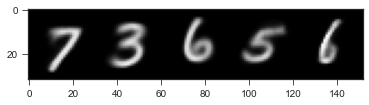

[45-239] Loss: 7414.686167399089


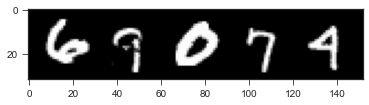

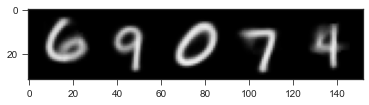

[46-239] Loss: 7413.991603597005


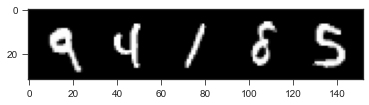

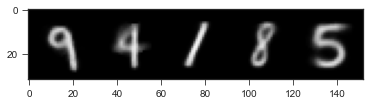

[47-239] Loss: 7412.152154541016


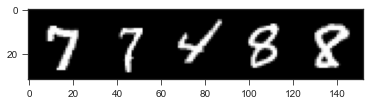

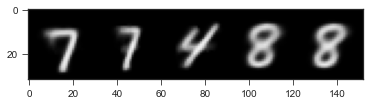

[48-239] Loss: 7406.204561360677


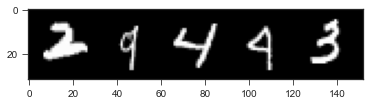

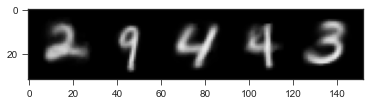

[49-239] Loss: 7405.955301920573


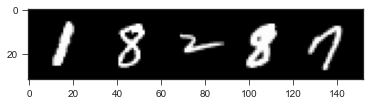

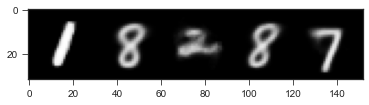

Training done (Duration: 29.41 min)


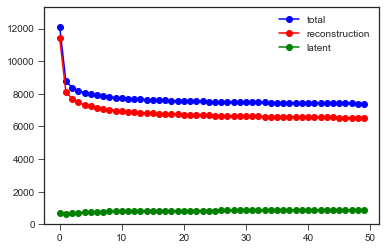

In [4]:
# TRAINING
num_epochs = 50
start_time = time.time()
running_total_losses = list()
running_reconstruction_losses = list()
running_latent_losses = list()
# Loop over epochs
for epoch in range(num_epochs):
    running_total_loss = 0.0
    running_reconstruction_loss = 0.0
    running_latent_loss = 0.0
    num_batches = 0
    # Loop over batches
    for batch_index, (inputs, one_hot_labels) in enumerate(train_loader):
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs, mu, log_var = net(inputs, one_hot_labels)
        
        # Calculate the loss
        total_loss, reconstruction_loss, latent_loss = criterion_func(inputs, outputs, mu, log_var)
        
        # Calculate the backward pass (and thereby set the gradients of the parameters)
        total_loss.backward()
        
        # Update the parameters by performing an optimizer step
        optimizer.step()
        
        # Add the loss to the running loss
        num_batches += 1
        running_total_loss += total_loss.item()
        running_reconstruction_loss += reconstruction_loss.item()
        running_latent_loss += latent_loss.item()
        
        # Display results if needed
        #if batch_index%2000==1999:
        #if batch_index%100==99:
        #if batch_index%50==49:
        
    # At the end of the batch, display progress
    #print(f"[{epoch}-{batch_index}] Loss: {running_total_loss/num_batches}")
    print(f"[{epoch}] Loss: {running_total_loss/num_batches}")
    imshow(inputs)
    imshow(outputs)
    running_total_losses.append(running_total_loss/num_batches)
    running_reconstruction_losses.append(running_reconstruction_loss/num_batches)
    running_latent_losses.append(running_latent_loss/num_batches)

    # Set runners back to zero
    running_total_loss = 0.0
    running_reconstruction_loss = 0.0
    running_latent_loss = 0.0
    num_batches = 0
    
print(f"Training done (Duration: {(time.time()-start_time)/60:.2f} min)")
plt.figure
plt.plot(running_total_losses, 'bo-', label='total')
plt.plot(running_reconstruction_losses, 'ro-', label='reconstruction')
plt.plot(running_latent_losses, 'go-', label='latent')
plt.ylim([0, np.max(running_total_losses)*1.1])
plt.legend()
plt.show()

# Store model
PATH = './mnist_net_cvae.pth'
torch.save(net.state_dict(), PATH)

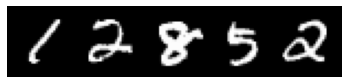

4 1 9 5 7


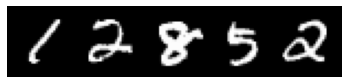

In [8]:
########################################################
# EVALUATE ON TEST SET
########################################################
# Evaluate on test images
dataiter = iter(test_loader)
inputs, labels = dataiter.next()
inputs, labels = dataiter.next()

# Display some images
imshow(images, labels=labels)

# Load the network
net = Net()
net.load_state_dict(torch.load(PATH))

# Get Ouput
outputs, mu, log_var = net(inputs, labels)

# Display auto-encoded images
imshow(images)


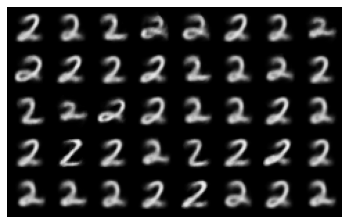

torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 2])
torch.Size([40, 1, 28, 28])


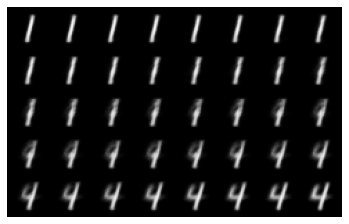

In [70]:
###############################################################
# Sample random images and morph images between the classes
###############################################################

# Load the network
net = Net()
net.load_state_dict(torch.load(PATH))

# Sampling
num_samples = 40
samples = net.sample(num_samples=num_samples, label=2)
imshow(samples, num_images_display=num_samples)

# Morphing
num_morph_steps = 40
morphs = net.morph(label_1=1, label_2=4, num_steps=num_morph_steps)
imshow(morphs, num_images_display=num_morph_steps)

# with torch.no_grad():
#     plt.figure
#     for (inputs, one_hot_labels) in train_loader:
#         mu, _ = net.encode(inputs, one_hot_labels)
#         plt.plot(mu[:, 0], mu[:, 1], 'bo')
#     plt.show()